<a href="https://colab.research.google.com/github/anphantt2406/Heritage-Health-Prize/blob/main/3_Model_DroppedVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/HHP_release3/data_processed

Mounted at /content/drive
/content/drive/My Drive/HHP_release3/data_processed


#Import Library

In [2]:
import glob
import math
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn import datasets, ensemble
from sklearn.datasets import make_regression

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#Define some needed function

Predictions are evaluated using root mean squared logarithmic error, referred to henceforth as RMSLE.

$$\varepsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(log(p_i+1) - log(a_i+1)^2 \right )}$$

Where:



*   $i$ is a patient's unique MemberID
*   $n$ is the total number of patients
*   $p_i$ is the prediction made for patient $i$
*   $a_i$ is the actual number of days spent in the hospital by patient $i$





In [3]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [4]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [5]:
def eval(model, X_test, y_test, name = None):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.clip(min=0)
    pred_y = pred_y.clip(max=15)
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,pred_y)
    from sklearn.metrics import mean_squared_log_error
    err = math.sqrt(mean_squared_log_error(y_test,pred_y))
    print("RMSLE of", name, ": %.4f" %rmsle)
    print("R2 value of", name, ": %.4f" %r2)
    print("Err value of", name, ": %.4f" %err)

In [6]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

#Prepare data for training and testing

In this notebook, we use Claims data in Year 1 for training and validation, Claims data in Year 2 for testing.

In [7]:
dataY1_df = pd.read_csv('fulldataY1.csv')
dataY2_df = pd.read_csv('fulldataY2.csv')

In [8]:
dataY1 = dataY1_df.drop("MemberID", axis = 1)
y = dataY1['TARGET']
X = dataY1.drop(['TARGET'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [10]:
dataY2 = dataY2_df.drop("MemberID", axis = 1)
y_test = dataY2['TARGET']
X_test = dataY2.drop(['TARGET'], axis = 1)
X_test = scaler.transform(X_test)

# Regression

## MODEL 1: Linear Regression

RMSLE of linear regression : 0.2203
R2 value of linear regression : 0.4575
Err value of linear regression : 0.2203


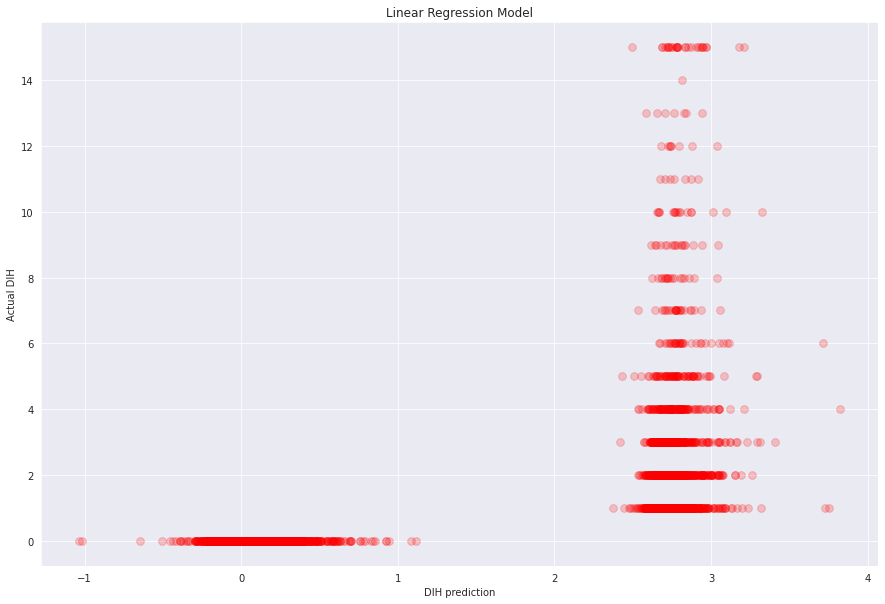

In [11]:
# Create linear regression object
model_1 = LinearRegression()
# Train the model using the training sets
model_1.fit(X_train, y_train)
# Predict on Test set
y_pred_1 = model_1.predict(X_valid)

# Evaluation on Validation set
eval(model_1, X_valid, y_valid,'linear regression')

plt.figure(figsize = (15,10))
plt.scatter(y_pred_1, y_valid, alpha=.2, s = 60, color='r') #alpha helps to show overlapping data
plt.xlabel('DIH prediction')
plt.ylabel('Actual DIH')
plt.title('Linear Regression Model')
plt.show()

## MODEL 2: Stochastic Gradient Descent

In [12]:
from sklearn.linear_model import SGDRegressor

model_2 = SGDRegressor(max_iter=3000, tol=1e-1)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_valid)
eval(model_2, X_valid, y_valid, 'Stochastic Gradient Descent')

RMSLE of Stochastic Gradient Descent : 0.2363
R2 value of Stochastic Gradient Descent : 0.4401
Err value of Stochastic Gradient Descent : 0.2363


In [13]:
model_2i = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False)
model_2i.fit(X_train, y_train)
eval(model_2i, X_valid, y_valid, 'Lasso regression')

RMSLE of Lasso regression : 0.2194
R2 value of Lasso regression : 0.4584
Err value of Lasso regression : 0.2194


##MODEL 3: Neural Network

In [14]:
#(i) Neural Network with default hyperparameters
model_3i = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred_3 = model_3i.predict(X_valid)
eval(model_3i, X_valid, y_valid, 'Neural Network_default')

RMSLE of Neural Network_default : 0.3305
R2 value of Neural Network_default : 0.3473
Err value of Neural Network_default : 0.3305


In [15]:
#(ii) random hyperparameter
model_3ii = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=7, learning_rate='adaptive',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3ii.fit(X_train, y_train)
eval(model_3ii, X_valid, y_valid , 'Neural Network_random')

Iteration 1, loss = 1.18234720
Iteration 2, loss = 0.78049627
Iteration 3, loss = 0.64600579
Iteration 4, loss = 0.55998578
Iteration 5, loss = 0.52835307
Iteration 6, loss = 0.51569118
Iteration 7, loss = 0.50847934
Iteration 8, loss = 0.50238557
Iteration 9, loss = 0.49980670
Iteration 10, loss = 0.49654210
Iteration 11, loss = 0.49330923
Iteration 12, loss = 0.49215880
Iteration 13, loss = 0.49110251
Iteration 14, loss = 0.48932582
Iteration 15, loss = 0.48793384
Iteration 16, loss = 0.48756642
Iteration 17, loss = 0.48652201
Iteration 18, loss = 0.48534367
Iteration 19, loss = 0.48489730
Iteration 20, loss = 0.48379080
Iteration 21, loss = 0.48329487
Iteration 22, loss = 0.48263261
Iteration 23, loss = 0.48125255
Iteration 24, loss = 0.48108917
Iteration 25, loss = 0.47984115
Iteration 26, loss = 0.47925709
Iteration 27, loss = 0.47895111
Iteration 28, loss = 0.47803458
Iteration 29, loss = 0.47763693
Iteration 30, loss = 0.47707023
Iteration 31, loss = 0.47648707
Iteration 32, los

**Hyperparameter Optimization using Grid Search**

In [16]:
#parameter_grid = {'hidden_layer_sizes': [i for i in range(1,10)],
#                  'activation': ['tanh', 'relu'],
#                  'solver': ['sgd','adam'],
#                  'learning_rate': ['constant'],
#                  'learning_rate_init': [0.001],
#                  'alpha': [0.0001],
#                  'max_iter': [1000],}

#rgr = GridSearchCV(MLPRegressor(), parameter_grid,
#                   cv = 5, verbose=True, pre_dispatch='2*n_jobs')
#rgr.fit(X_train, y_train)

#train_mse = mean_squared_error(y_train, rgr.predict(X_train))
#test_mse = mean_squared_error(y_valid, rgr.predict(X_valid))

#print(rgr.best_params_)
#print(rgr.best_score_)
#print("Train MSE:", np.round(train_mse,2))
#print("Test MSE:", np.round(test_mse,2))

In [17]:
from sklearn.neural_network import MLPRegressor

model_3 = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=2, learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3.fit(X_train, y_train)
eval(model_3, X_valid, y_valid, 'Neural Network_gridsearch')

Iteration 1, loss = 1.03045764
Iteration 2, loss = 0.79248017
Iteration 3, loss = 0.66784642
Iteration 4, loss = 0.57301855
Iteration 5, loss = 0.52681027
Iteration 6, loss = 0.51025028
Iteration 7, loss = 0.50219938
Iteration 8, loss = 0.49820641
Iteration 9, loss = 0.49603329
Iteration 10, loss = 0.49529482
Iteration 11, loss = 0.49326612
Iteration 12, loss = 0.49301571
Iteration 13, loss = 0.49252155
Iteration 14, loss = 0.49133586
Iteration 15, loss = 0.49143007
Iteration 16, loss = 0.49022740
Iteration 17, loss = 0.49069601
Iteration 18, loss = 0.49036600
Iteration 19, loss = 0.49012319
Iteration 20, loss = 0.49012261
Iteration 21, loss = 0.48957934
Iteration 22, loss = 0.48928028
Iteration 23, loss = 0.48913779
Iteration 24, loss = 0.48972622
Iteration 25, loss = 0.48836510
Iteration 26, loss = 0.48877061
Iteration 27, loss = 0.48818166
Iteration 28, loss = 0.48767205
Iteration 29, loss = 0.48772259
Iteration 30, loss = 0.48795444
Iteration 31, loss = 0.48749515
Iteration 32, los

## MODEL 4: XGBoost -  Gradient Boost Linear Regression Function

In [18]:
reg = ensemble.GradientBoostingRegressor(n_estimators = 500,
          max_depth = 4,
          min_samples_split= 5,
          learning_rate = 0.01,
          loss = 'ls')
reg.fit(X_train, y_train)
eval(reg, X_valid, y_valid,'Gradient Boosting Regressor')

RMSLE of Gradient Boosting Regressor : 0.2009
R2 value of Gradient Boosting Regressor : 0.4764
Err value of Gradient Boosting Regressor : 0.2009


In [19]:
# Set XGBoost DataMatrix
dmatrix_train = xgboost.DMatrix(data=X_train,label=y_train)
dmatrix_test = xgboost.DMatrix(data=X_test,label=y_test)

[07:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:1.36785	train-rmse:1.39012	test-RMSLE:0.494484	train-RMSLE:0.499056
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.359	train-rmse:1.38171	test-RMSLE:0.48505	train-RMSLE:0.490229
[2]	test-rmse:1.35166	train-rmse:1.3747	test-RMSLE:0.477001	train-RMSLE:0.482649
[3]	test-rmse:1.34549	train-rmse:1.36876	test-RMSLE:0.470052	train-RMSLE:0.476059
[4]	test-rmse:1.34024	train-rmse:1.36368	test-RMSLE:0.463995	train-RMSLE:0.470278
[5]	test-rmse:1.33574	train-rmse:1.35929	test-RMSLE:0.458681	train-RMSLE:0.465173
[6]	test-rmse:1.33184	train-rmse:1.35547	test-RMSLE:0.453991	train-RMSLE:0.460644
[7]	test-rmse:1.32845	train-rmse:1.35213	test-RMSLE:0.449837	train-RMSLE:0.456611
[8]	test-rmse:1.32549	train-rmse:1.34919	test-RMSLE:0.446146	train-RMSLE:0.

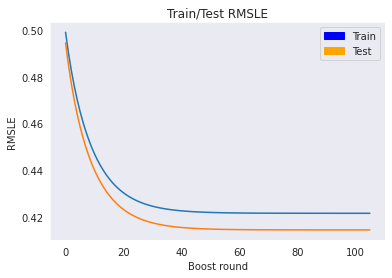

RMSLE Train set: 0.421492


In [20]:
# XGBoost
params = {'objective': 'reg:linear', 'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.5, 'learning_rate': 0.1, 'max_depth': 15, 'lambda': 10,
          'booster': 'gblinear'}
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])

# Final Results

In [21]:
eval(model_1, X_test, y_test,'linear regression')
print('******')
eval(model_2, X_test, y_test, 'Stochastic Gradient Descent')
print('******')
eval(model_2i, X_test, y_test, 'Lasso regression')
print('******')
eval(model_3i, X_test, y_test, 'Neural Network_default')
print('******')
eval(model_3ii, X_test, y_test, 'Neural Network_random')
print('******')
eval(model_3, X_test, y_test, 'Neural Network_gridsearch')
print('******')
eval(reg, X_test, y_test,'Gradient Boosting Regressor')
print('******')
print('Gradient Boost Linear Regression _ RMSLE Test set:', xgb_results['test']['RMSLE'][-1]) 

RMSLE of linear regression : 0.2196
R2 value of linear regression : 0.4585
Err value of linear regression : 0.2196
******
RMSLE of Stochastic Gradient Descent : 0.2369
R2 value of Stochastic Gradient Descent : 0.4413
Err value of Stochastic Gradient Descent : 0.2369
******
RMSLE of Lasso regression : 0.2186
R2 value of Lasso regression : 0.4591
Err value of Lasso regression : 0.2186
******
RMSLE of Neural Network_default : 0.3278
R2 value of Neural Network_default : 0.3427
Err value of Neural Network_default : 0.3278
******
RMSLE of Neural Network_random : 0.2205
R2 value of Neural Network_random : 0.4418
Err value of Neural Network_random : 0.2205
******
RMSLE of Neural Network_gridsearch : 0.2075
R2 value of Neural Network_gridsearch : 0.4748
Err value of Neural Network_gridsearch : 0.2075
******
RMSLE of Gradient Boosting Regressor : 0.1987
R2 value of Gradient Boosting Regressor : 0.4821
Err value of Gradient Boosting Regressor : 0.1987
******
Gradient Boost Linear Regression _ RMS

In [22]:
pred_y = xgb_model.predict(dmatrix_test)

submission = pd.DataFrame()
submission['MemberID'] = dataY2_df['MemberID']

pred_y = pred_y.clip(min=0)
pred_y = pred_y.clip(max=15)
# pred_y = pred_y.astype(int)

submission['DIH'] = pred_y
submission.groupby(['DIH']).size()

DIH
0.213368    1
0.215793    1
0.215946    1
0.216009    2
0.216027    2
           ..
1.148928    1
1.165810    1
1.205070    1
1.218391    1
1.244732    1
Length: 66372, dtype: int64

In [23]:
submission[submission['DIH']>=1]

,MemberID,DIH
760,1139828,1.001359
1811,2689993,1.007715
4264,6362123,1.021909
4408,6568367,1.218391
4665,6911910,1.056170
...,...,...
65766,98134353,1.068563
66279,98889976,1.010414
66311,98928951,1.022010
66358,98999739,1.048670
